In [43]:
# Raw Package
import numpy as np
import pandas as pd
import time

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

import math
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

In [44]:
def show_chart(data,stockName):
    #declare figure
    fig = go.Figure()

    #Candlestick
    fig.add_trace(go.Candlestick(x=data.index,
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'], name = 'market data'))

    # Add titles
    fig.update_layout(
        title='{} live share price evolution'.format(stockName),
        yaxis_title='Stock Price (USD per Shares)')

    # X-Axes
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=15, label="15m", step="minute", stepmode="backward"),
                dict(count=45, label="45m", step="minute", stepmode="backward"),
                dict(count=1, label="HTD", step="hour", stepmode="todate"),
                dict(count=3, label="3h", step="hour", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    #Show
    fig.show()

def extractData(stockName=None,period=None,interval=None,start=None,end=None):
    if(period!=None):
        data = yf.download(tickers=stockName, period=period, interval=interval)
    else:
        data = yf.download(tickers=stockName, start="2009-05-04", end="2020-05-04", interval=interval)
    return data
    
stockName = 'JPM'
data=extractData(stockName=stockName,period='20y',interval='1d')
# data=extractData(stockName='TATASTEEL',start="2009-05-04", end="2020-05-04",interval='1m')
# show_chart(data,stockName)
data.to_excel(f"{stockName}.xlsx")
Open = data['Open'],
high = data['High']
low = data['Low'],
close = data['Close']
adjClose = data['Adj Close']
volume = data['Volume']


highLow = []
openClose = []
for H,L in zip(high,low):
    highLow.append(H-L)
for O,C in zip(Open,close):
    openClose.append(O-C)

sevenDaysMA = data.rolling(window=7).mean()
fourteenDaysMA = data.rolling(window=14).mean()
twentyoneDaysMA = data.rolling(window=21).mean()
sevenDaysSD = data.rolling(window=7).std()

[*********************100%***********************]  1 of 1 completed


In [45]:
dataFrame = pd.DataFrame(data)
dataFrame['highLow'] = highLow[0]
dataFrame['openClose'] = openClose[0]
dataFrame['sevenDaysMA'] = sevenDaysMA['Close']
dataFrame['fourteenDaysMA'] = fourteenDaysMA['Close']
dataFrame['twentyoneDaysMA'] = twentyoneDaysMA['Close']
dataFrame['sevenDaysSD'] = sevenDaysSD['Close']

dataFrame.drop(dataFrame.columns[[0,1,2,4,5]], axis=1, inplace=True)

for i in dataFrame:
    values=dataFrame[i].isnull()
    for j in range(len(values)):
        if(values[j]==True):
            dataFrame[i][j]=0

# print(dataFrame)
X = dataFrame[['highLow','openClose','sevenDaysMA','fourteenDaysMA','twentyoneDaysMA','sevenDaysSD']]
Y = dataFrame[['Close']]

factor = 0.80
length = X.shape[0]
total_for_train = int(length*factor)

X_train = X[:total_for_train]
Y_train = Y[:total_for_train]
X_test = X[total_for_train:]
Y_test = Y[total_for_train:]

In [46]:
classifier = Sequential()
classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [])
classifier.fit(X_train, Y_train, batch_size = 128, epochs = 25, validation_split=0.05)

Train on 3826 samples, validate on 202 samples
Epoch 1/25
3826/3826 [==============================] - 0s 27us/step - loss: 2842.4731 - val_loss: 11208.7041
Epoch 2/25
3826/3826 [==============================] - 0s 8us/step - loss: 2395.0487 - val_loss: 6648.7186
Epoch 3/25
3826/3826 [==============================] - 0s 8us/step - loss: 721.0767 - val_loss: 33.2678
Epoch 4/25
3826/3826 [==============================] - 0s 7us/step - loss: 27.0472 - val_loss: 40.6220
Epoch 5/25
3826/3826 [==============================] - 0s 6us/step - loss: 13.0332 - val_loss: 85.6870
Epoch 6/25
3826/3826 [==============================] - 0s 7us/step - loss: 11.1990 - val_loss: 70.7344
Epoch 7/25
3826/3826 [==============================] - 0s 6us/step - loss: 9.4110 - val_loss: 58.6132
Epoch 8/25
3826/3826 [==============================] - 0s 6us/step - loss: 6.6254 - val_loss: 21.9988
Epoch 9/25
3826/3826 [==============================] - 0s 6us/step - loss: 4.4577 - val_loss: 14.9647
Epoch 10/

In [47]:
predictions = classifier.predict(X_test)
print(len(predictions),'\n',predictions[:])

1008 
 [[106.21416 ]
 [106.775536]
 [106.05994 ]
 ...
 [139.63272 ]
 [136.92    ]
 [135.42076 ]]


In [48]:
trainScore = classifier.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = classifier.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

def make_excelsheet(predictions,Y_test):
    from xlwt import Workbook
    
    # Workbook is created
    wb = Workbook()
    
    # add_sheet is used to create sheet.
    sheet1 = wb.add_sheet('Sheet 1')
    sheet1.write(0, 0, 'Original')
    sheet1.write(0, 1, 'Predictions')
    sheet1.write(0, 2, 'Difference')
    sheet1.write(0, 3, 'Factor')
    for i in range(len(predictions)):
        sheet1.write(i+1, 0, '{}'.format(Y_test['Close'][i]))
        sheet1.write(i+1, 1, '{}'.format(predictions[i][0]))
        sheet1.write(i+1, 2, '{}'.format(Y_test['Close'][i] - predictions[i][0]))
        sheet1.write(i+1, 3, '{}'.format(Y_test['Close'][i] / predictions[i][0]))
    wb.save('Predictions.xls')

make_excelsheet(predictions,Y_test)

# Train Score: 7.46 MSE (2.73 RMSE)
# Test Score: 148.71 MSE (12.19 RMSE)

Train Score: 2.63 MSE (1.62 RMSE)
Test Score: 18.43 MSE (4.29 RMSE)


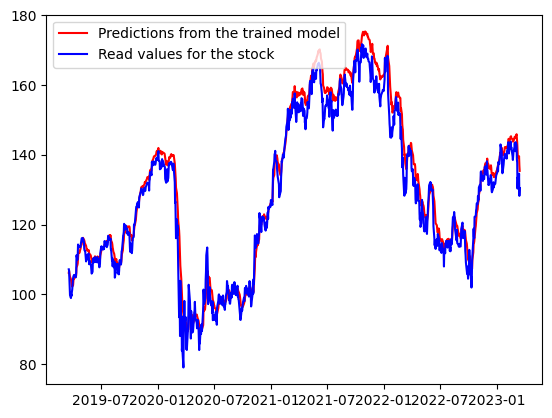

In [49]:
if 'ClosePredictions' not in Y_test.columns:
    Y_test.insert(0, "ClosePredictions", predictions, True)
import matplotlib.pyplot as plt
plt.plot(Y_test['ClosePredictions'],color='red', label='Predictions from the trained model')
plt.legend(loc='upper left')
plt.plot(Y_test['Close'],color='blue', label='Read values for the stock')
plt.legend(loc='upper left')
plt.show()

Y_test.to_excel("Predictions_CLose.xlsx")